# Load data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=3, linewidth=120)
import sys
sys.path.append("..")
from scem.datasets import *

import torch 
import torch.nn as nn
import numpy as np
import torch.distributions as td


In [524]:
dname = "banana"
p = load_data(dname, D=2, noise_std = 0.0, seed=0, itanh=False, whiten=False )

x = p.sample(1000)
x_eval = p.sample(100)

softplus = nn.functional.softplus

In [613]:
import torch 
import torch.nn as nn
import numpy as np
import torch.distributions as td


class EBM(nn.Module):
    
    '''
    EBM 
    '''
    
    def __init__(self, Dx, Dz, Dh):
        
        super().__init__()
        
        self.layer_1 = nn.Linear(Dz+Dx, Dh)
        self.layer_2 = nn.Linear(Dh, Dh)
        self.layer_out = nn.Linear(Dh, 1)
    
    def forward(self, X, Z):
        
        if X.ndim == Z.ndim-1:
            X = torch.stack([X]*Z.shape[0], 0)
        
        XZ = torch.cat([X, Z], axis=-1)
        h  = torch.relu(self.layer_1(XZ))
        h  = torch.relu(self.layer_2(h))
        E  = self.layer_out(h)
        return E[...,0]
    
    
class Posterior(nn.Module):
    '''
    Posterior is a factorised normal
    '''
    def __init__(self, Dx, Dh, Dz):
        
        super().__init__()
        
        self.layer_1 = nn.Linear(Dx, Dh)
        self.layer_2 = nn.Linear(Dh, Dh)
        self.layer_2_m = nn.Linear(Dh, Dz)
        self.layer_2_v = nn.Linear(Dh, Dz)
        
    def forward(self, x):
        
        h = self.layer_1(x).tanh()
        h = self.layer_2(h).tanh()
        m = self.layer_2_m(h)
        v = self.layer_2_v(h)
        v = nn.functional.softplus(v)
        
        return td.Normal(m, v)
        

# dimensionality of model 
Dx = 2
Dz = 2
Dh = 100

# label ratio, only nu
nu = 1

emb = EBM(Dx, Dz, Dh)   

recog   = Posterior(Dx, Dh, Dz)
        
# noise distribution
p_noise = td.Normal(torch.zeros(Dx), torch.ones(Dx)*3)

In [614]:
def VNCE_loss(xs):
    
    '''
    Variational NCE objective
    '''
    m = 5
    xs = torch.as_tensor(xs, dtype=torch.float32)
    
    
    qs_x = recog(xs)
    zs_x = qs_x.rsample([m])
    E_x = emb(xs, zs_x)
    ys = p_noise.sample([xs.shape[0]])
    
    qs_y = recog(ys)
    zs_y = qs_y.rsample([m])
    E_y = emb(ys, zs_y)
    # Equation 13, 
    # http://proceedings.mlr.press/v89/rhodes19a/rhodes19a.pdf
    sig = lambda x: torch.log(1. + x )
    bound = - sig(nu * (p_noise.log_prob(xs).sum(-1) + qs_x.log_prob(zs_x).sum(-1) - E_x ).exp()).mean(0) -\
             nu * sig( 1. / nu  / p_noise.log_prob(ys).sum(-1).exp() * (E_y - qs_y.log_prob(zs_y).sum(-1)).exp().mean(0) )
    
    return -bound.mean()

In [615]:
opt = torch.optim.Adam(emb.parameters(), lr=1e-4, weight_decay=1e-3)
opt_recog = torch.optim.Adam(recog.parameters(), lr=1e-4, weight_decay=1e-3)

In [616]:
losses = []
for i in range(30000):
    
    loss = VNCE_loss(x)
    
    opt.zero_grad()
    opt_recog.zero_grad()

    loss.backward()
    opt.step()
    opt_recog.step()
    
    losses += loss.item(),

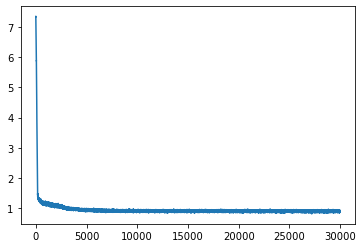

In [617]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [618]:
# form a grid for numerical normalisation
from itertools import product
ngrid = 50
grid = torch.linspace(-10,10,ngrid)
xz_eval = torch.tensor(list(product(*[grid]*4)))
x_eval = xz_eval[:,:2]
z_eval = xz_eval[:,2:]

In [619]:
# true log density
E_true = p.logpdf_multiple(torch.tensor(list(product(*[grid]*2))))
E_true -= E_true.max()

In [620]:
# EBM log density
E_eval = emb(x_eval, z_eval).reshape(ngrid,ngrid,ngrid,ngrid).exp().detach()
E_eval /= E_eval.sum()
E_eval = E_eval.sum(-1).sum(-1)
E_eval.log_()
E_eval -= E_eval.max()
# E_eval = E_eval.sum(-1).sum(-1)

In [621]:
def normalise(E):
    if isinstance(E, np.ndarray):
        E = np.exp(E)
    else:
        E = E.exp()
    E /= E.sum()
    return E

(-10.0, 10.0)

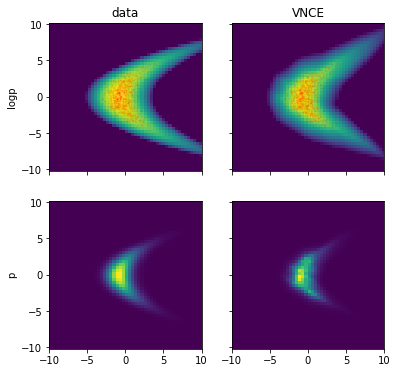

In [622]:
fig, axes = plt.subplots(2,2,figsize=(6,6), sharex=True, sharey=True)


ax = axes[0,0]
ax.pcolor(grid, grid,E_true.reshape(ngrid,ngrid), shading='auto', vmin=-10, vmax=0)
ax.scatter(x[:,1], x[:,0], c="r", s=1, alpha=0.05)


ax = axes[1,0]
ax.pcolor(grid, grid,normalise(E_true).reshape(ngrid,ngrid), shading='auto')

ax = axes[0,1]
ax.pcolor(grid, grid,E_eval,shading='auto', vmin=-10, vmax=0, )
ax.scatter(x[:,1], x[:,0], c="r", s=1, alpha=0.05)

ax = axes[1,1]
ax.pcolor(grid, grid,normalise(E_eval),shading='auto' )
ax.scatter(x[:,1], x[:,0], c="r", s=1, alpha=0.0)



axes[0,0].set_ylabel("logp")
axes[1,0].set_ylabel("p")

axes[0,0].set_title("data")
axes[0,1].set_title("VNCE")

axes[0,0].set_xlim(-10,10)